## Solution to Assignment 4

We have provided a template to help get you started, as part of this assignment you will fill in the missing sections pertaining to the document

In [ ]:
! pip install pandas networkx matplotlib torch plotly torch_geometric pkbar

  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached matplotlib-3.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached plotly-6.0.1-py3-none-any.whl.metadata (6.7 kB)
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached pkbar-0.5-py3-none-any.whl.metadata (3.8 kB)
  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached contourpy-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.57.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (102 kB)
  Using cached kiwisolver-1.4.8-cp311-cp311-manylinux_2_17_x86_64.manylinux2

### Q1. Load the dataset [5 points]

We will be using the MNISTSuperPixels dataset. See the original paper here: https://arxiv.org/pdf/1611.08402

We will not be going into the depth they did here, rather just using their datasets to get a feel for implementing Graph Convolutional Neural Networks on a familiar dataset.

In [ ]:
import torch
from torch_geometric.datasets import MNISTSuperpixels
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

import matplotlib.pyplot as plt
import networkx as nx
import random

# 1. Load the dataset
dataset = MNISTSuperpixels(root='/tmp/MNISTSuperpixels')

# 2. Shuffle and split
# Use a traditional splitting of 75/15/15 (train/val/test)
######### Your code here ##############

total_size = len(dataset)
train_size = int(0.75 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Shuffle the dataset
indices = list(range(total_size))
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

train_dataset = dataset[train_indices]
val_dataset = dataset[val_indices]
test_dataset = dataset[test_indices]

#######################################


print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

# 3. Create your dataloaders
# Create training, validation and testing dataloaders
# You can use any batch size you want - it may effect your peformance.
######### Your code here ##############

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


#######################################


Extracting /tmp/MNISTSuperpixels/raw/MNISTSuperpixels.zip
Processing...
Done!


Train: 45000 | Val: 9000 | Test: 6000


#### Visualize the dataset

We want to visualize the dataset you have just created. Recall that these are no longer "images", but rather graph representations of MNIST.

You may want to run this a few times to see the different possible graphs that could occur.

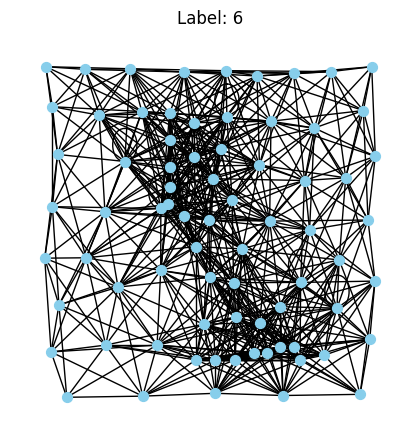

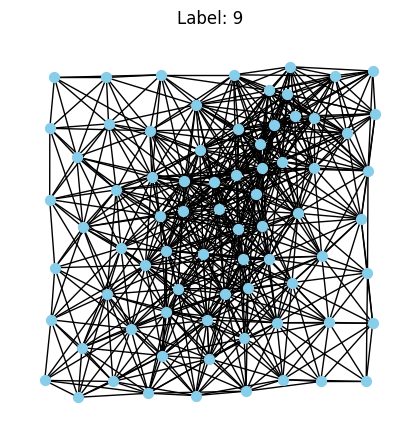

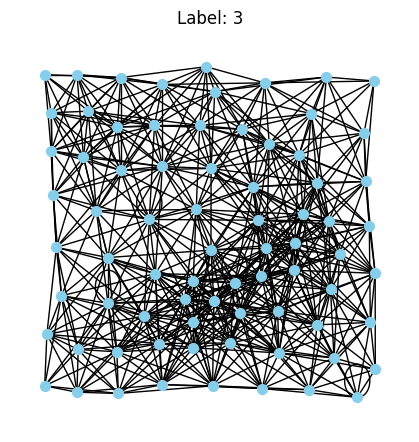

In [ ]:
def visualize_graph(data, title=None):
    G = to_networkx(data, node_attrs=['x'], to_undirected=True)

    # Extract 2D coordinates for layout (superpixel positions)
    pos = {i: data.pos[i].numpy() for i in range(data.num_nodes)}

    plt.figure(figsize=(4, 4))
    nx.draw(G, pos, node_size=50, with_labels=False, node_color='skyblue')
    if title:
        plt.title(title)
    plt.show()

#Pick some random samples to visualize
for i in range(3):
    idx = random.randint(0, len(train_dataset)-1)
    visualize_graph(train_dataset[idx], title=f"Label: {train_dataset[idx].y.item()}")

### Q2. Create a basic GCN [20 points]

We will use torch_geometric here. There are a few layers we are going to need:

- **GCNConv**: Graph Convolutional Layer from `torch_geometric.nn`.
- **Global Mean Pooling**: Aggregates node features to graph-level representation.
- **ReLU**: Activation function after each layer (except the final one).
- **Linear**: Fully connected layers for classification.


The network should take:

* x: node features
* edge_index: graph connectivity
* batch: batch assignment vector (for pooling)

      Input → GCNConv (input_dim → 128) → ReLU  

      → GCNConv (128 → 64) → ReLU  

      → GCNConv (64 → 128) → ReLU

      → Global Mean Pooling  

      → Linear (128 → 64) → ReLU  

      → Linear (64 → num_classes) → Output

Where output should be the raw logits (no final activation)


Instead of implementing the activation function as part of the class, i.e., self.activation = nn.ReLU() - directly apply it in the forward call:

As an example - `self.fc(x).relu()`

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, input_dim, num_classes):
        super(GCN, self).__init__()
        # First GCN layer: input_dim -> 128
        self.conv1 = GCNConv(input_dim, 128)

        # Second GCN layer: 128 -> 64
        self.conv2 = GCNConv(128, 64)

        # Third GCN layer: 64 -> 128
        self.conv3 = GCNConv(64, 128)

        # Linear layers for classification
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x, edge_index, batch):
        # First GCN layer + ReLU
        x = self.conv1(x, edge_index).relu()

        # Second GCN layer + ReLU
        x = self.conv2(x, edge_index).relu()

        # Third GCN layer + ReLU
        x = self.conv3(x, edge_index).relu()

        # Global mean pooling (node features -> graph features)
        x = global_mean_pool(x, batch)

        # First fully connected layer + ReLU
        x = self.fc1(x).relu()

        # Second fully connected layer (output layer)
        x = self.fc2(x)

        return x


### Q3. Implement the training procedure [30 points]

You will implement the training procedure and the validation procedure. We have provided you some hints for different things you should be calculating in the training portion. For the validation portion, we leave this up to you entirely. Make sure the values that you are seeing during training make sense in terms of magnitude - i.e., divisions by number of batches or number of elements is correct. Feel free to change this however works for you.

The pkbar import is a handy package that makes pytorch trainings more akin to tensorflow's .fit() function in terms of output.

The training function will return the trained model, along with a dictionary called history that can be used for plotting your metrics during training.

In [ ]:
import pkbar

def trainer(net, train_loader, val_loader, num_epochs=100, lr=1e-3, device='cuda'):
    # Setup random seed
    torch.manual_seed(8)
    torch.cuda.manual_seed(8)
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    print("Training Size: {0}".format(len(train_loader.dataset)))
    print("Validation Size: {0}".format(len(val_loader.dataset)))

    # Create your optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    print('===========  Optimizer  ==================:')
    print('      LR:', lr)
    print('      num_epochs:', num_epochs)
    print('')

    # Define your loss function, we are doing multiclass classification remember
    CCE = torch.nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # Progress bar setup
        kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=num_epochs)
        net.train()  # Set the model to training mode
        running_loss = 0.0
        running_acc = 0.0

        for i, data in enumerate(train_loader):
            data = data.to(device)  # Move data to the specified device (e.g., GPU)
            optimizer.zero_grad()

            # Forward pass of your models
            logits = net(data.x, data.edge_index, data.batch)

            # We want to monitor our accuracy during training
            pred = logits.argmax(dim=1)
            train_acc = pred.eq(data.y).sum().item() / data.num_graphs

            # Calculate your loss
            loss = CCE(logits, data.y)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Note we have per batch, and running metrics
            running_loss += loss.item() * data.num_graphs
            running_acc += train_acc * data.num_graphs
            kbar.update(i, values=[("loss", loss.item()),("acc:", train_acc)])

        # Track training loss
        history['train_loss'].append(running_loss / len(train_loader.dataset))
        history['train_acc'].append(running_acc / len(train_loader.dataset))

        ######################
        ## Validation phase ##
        ######################
        net.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for i, data in enumerate(val_loader):
                data = data.to(device)  # Move data to the specified device (e.g., GPU)

                # Forward pass
                out = net(data.x, data.edge_index, data.batch)

                # Compute validation metrics
                loss = CCE(out, data.y)
                val_loss += loss.item() * data.num_graphs

                pred = out.argmax(dim=1)
                val_acc += pred.eq(data.y).sum().item() / data.num_graphs * data.num_graphs

        # Average validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_acc /= len(val_loader.dataset)

        # Track validation loss and accuracy
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        kbar.add(1, values=[("val_loss", val_loss),("val_acc:", val_acc)])

    return net, history

In [ ]:
# Instantiate and train your model
# What is your input size? How many classes do we have?

# Get a sample from the dataset to determine input dimension
sample = dataset[0]
input_dim = sample.x.size(1)  # Features dimension
num_classes = 10  # MNIST has 10 classes (0-9)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(input_dim=input_dim, num_classes=num_classes).to(device)
model, history = trainer(model, train_loader, val_loader, num_epochs=100, lr=0.001, device=device)

Training Size: 45000
Validation Size: 9000
===========  Optimizer  ==================:
      LR: 0.001
      num_epochs: 100

Epoch: 1/100
704/704 [==============================] - 10s 14ms/step - loss: 2.2409 - acc:: 0.1462 - val_loss: 2.1152 - val_acc:: 0.2160
Epoch: 2/100
704/704 [==============================] - 6s 8ms/step - loss: 1.9538 - acc:: 0.2658 - val_loss: 1.9276 - val_acc:: 0.2709
Epoch: 3/100
704/704 [==============================] - 6s 8ms/step - loss: 1.9229 - acc:: 0.2741 - val_loss: 1.9822 - val_acc:: 0.2496
Epoch: 4/100
704/704 [==============================] - 6s 8ms/step - loss: 1.9101 - acc:: 0.2806 - val_loss: 1.9336 - val_acc:: 0.2789
Epoch: 5/100
704/704 [==============================] - 6s 8ms/step - loss: 1.9043 - acc:: 0.2816 - val_loss: 1.8853 - val_acc:: 0.2771
Epoch: 6/100
704/704 [==============================] - 6s 8ms/step - loss: 1.9000 - acc:: 0.2839 - val_loss: 1.8891 - val_acc:: 0.2804
Epoch: 7/100
704/704 [==============================] - 

### Q4. Plotting [5 points]

Plot the loss and accuracy curves using the history from training. Make sure to overlay both training and validation. Provide analysis on potential issues you see if any.

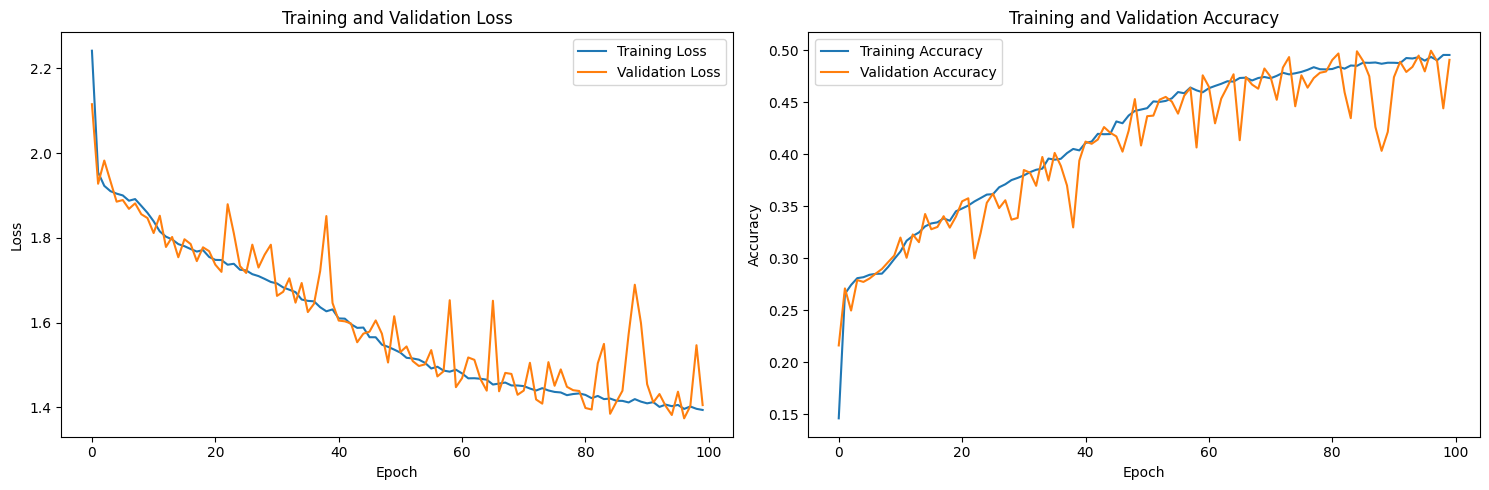

In [ ]:
def plot_loss(history):
    # Two individual plots, one for losses and one for accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()

    # Plot accuracies
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_loss(history)

From the plot, we can see that as training goes, both the training and validation loss declines, and when approaching 100 rounds, the rate of loss decrease slows down significantly, indicating that the model is converging.

### Q5. Implement a function to evaluate your model on the testing dataset [10 points]

We want to return two things:

1. Test accuracy
2. Confusion matrix on the test set (plot)

Hint: see what we have imported from sklearn and view the documentation. You might find some useful functions.

Provide some analysis as to what you see in terms of performance? Is this surprising? Are there biases towards any specific classes? Why?

In [ ]:
pip install scikit-learn

  Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.5 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.15.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.6 MB)
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


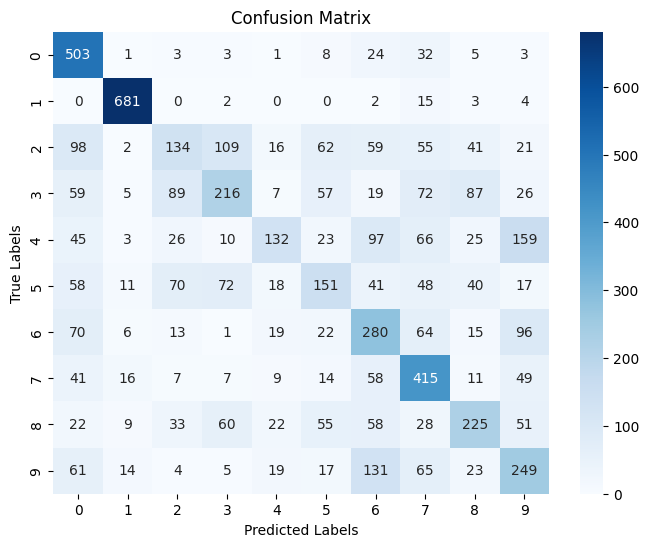

Test Accuracy: 0.4977


In [ ]:
import sklearn.metrics as metrics
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            # Forward pass
            logits = model(data.x, data.edge_index, data.batch)
            # Get class predictions
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()

            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate confusion matrix
    conf_matrix = metrics.confusion_matrix(all_labels, all_preds)

    # Calculate accuracy
    accuracy = metrics.accuracy_score(all_labels, all_preds)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    ax.set_title('Confusion Matrix')
    plt.show()

    return accuracy, conf_matrix

# Evaluate the model on the test set
test_accuracy, conf_matrix = evaluate_model(model, test_loader)

# Print the results
print(f"Test Accuracy: {test_accuracy:.4f}")

Best classified digits:

Digit 1 had the highest recognition rate, with about 0.96
Digit 0 and digit 7 also performed well, with accuracy rates of about 86% and 66% respectively

Worst classified digits:

Digit 4 had the lowest recognition rate, with only about 22% of samples correctly classified
Digit 4 and digit 2 also performed poorly, with accuracy rates of about 22% respectively

Common confusion patterns:

Digit 3 was often misclassified as digit 2
Digit 9 was often misclassified as digit 6
There was significant confusion between digits 2 and 3 (in both directions)

Digit shape analysis:

Digit 1 had the most unique shape and was hardly confused with other digits
There was more confusion between digits 2, 3, 5, and 8, which do have some similarities in graphic structure
Digits 6 and 9 had some confusion, which may be due to their similar shapes after rotation

These results are not surprising because:

Using a graph structure to represent an image will lose some local features and spatial relationships that traditional CNNs can capture
Numbers with similar shapes (such as 2 and 3, 4 and 9, 6 and 9) are more difficult to distinguish after conversion to a graph structure
Numbers with simple and unique structures (such as 1) are more likely to be correctly recognized

### Q6. Class wise accuracy [10 points]

The confusion matrix gives us a good indication of class wise performance, but might not be the easiest thing to look at. Lets instead provide the accuracy class wise, which is more easily interpetable perhaps.

While we could make this cleaner (i.e., combining the above function with the one below) and reduce computation, the dataset is small and therefore we are not worried. You can reuse some of the above function here, or if you want you can simply combine the two functions.

In [ ]:
def class_wise_accuracy(model, loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            logits = model(data.x, data.edge_index, data.batch)
            preds = logits.argmax(dim=1).cpu().numpy()
            labels = data.y.cpu().numpy()

            all_preds.append(preds)
            all_labels.append(labels)

    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Calculate class-wise accuracy
    class_acc = []
    for class_idx in np.unique(all_labels):
        # Get indices where the true label is the current class
        class_indices = np.where(all_labels == class_idx)[0]
        # Calculate accuracy for this class
        class_correct = np.sum(all_preds[class_indices] == all_labels[class_indices])
        class_accuracy = class_correct / len(class_indices)
        class_acc.append(class_accuracy)

    return np.array(class_acc)

# Calculate the class-wise accuracy on the test set
test_class_wise_acc = class_wise_accuracy(model, test_loader)

# Print the class-wise accuracy for each class
print("Class-wise accuracy:")
for i, acc in enumerate(test_class_wise_acc):
    print(f"Class {i}: {acc:.4f}")

Class-wise accuracy:
Class 0: 0.8628
Class 1: 0.9632
Class 2: 0.2245
Class 3: 0.3391
Class 4: 0.2253
Class 5: 0.2871
Class 6: 0.4778
Class 7: 0.6619
Class 8: 0.3996
Class 9: 0.4235


### Q7. Training with positional information of nodes [10 points]

In previous experiments, we have neglected information that might be very important for our task of classifiying digits - node position.

Modify the training script from above to also utilize this information in the form:

`data.x = torch.cat([data.x,data.pos],dim=1)`

You will need to think about how the shape of your input has changed with the addition of this new information

Train a new model with this additional information and provide the same metrics as above:

1.  `plot_loss()` - no changes required
2.  `evaluate_model()` - changes required for inputs
3.  `class_wise_accuracy()` - changes required for inputs

Provide analysis on how this additional information effects the performance of your model. Is this helpful information? Why?

Training Size: 45000
Validation Size: 9000
===========  Optimizer  ==================:
      LR: 0.001
      num_epochs: 100

Epoch: 1/100
704/704 [==============================] - 5s 8ms/step - loss: 2.2456 - acc:: 0.1481 - val_loss: 2.2055 - val_acc:: 0.1743
Epoch: 2/100
704/704 [==============================] - 5s 8ms/step - loss: 2.1459 - acc:: 0.2017 - val_loss: 2.0927 - val_acc:: 0.2303
Epoch: 3/100
704/704 [==============================] - 5s 8ms/step - loss: 2.0244 - acc:: 0.2526 - val_loss: 1.9930 - val_acc:: 0.2647
Epoch: 4/100
704/704 [==============================] - 5s 8ms/step - loss: 1.9344 - acc:: 0.2847 - val_loss: 1.9126 - val_acc:: 0.2858
Epoch: 5/100
704/704 [==============================] - 5s 8ms/step - loss: 1.8896 - acc:: 0.3034 - val_loss: 1.9055 - val_acc:: 0.2948
Epoch: 6/100
704/704 [==============================] - 6s 8ms/step - loss: 1.8442 - acc:: 0.3205 - val_loss: 1.8253 - val_acc:: 0.3169
Epoch: 7/100
704/704 [==============================] - 5s

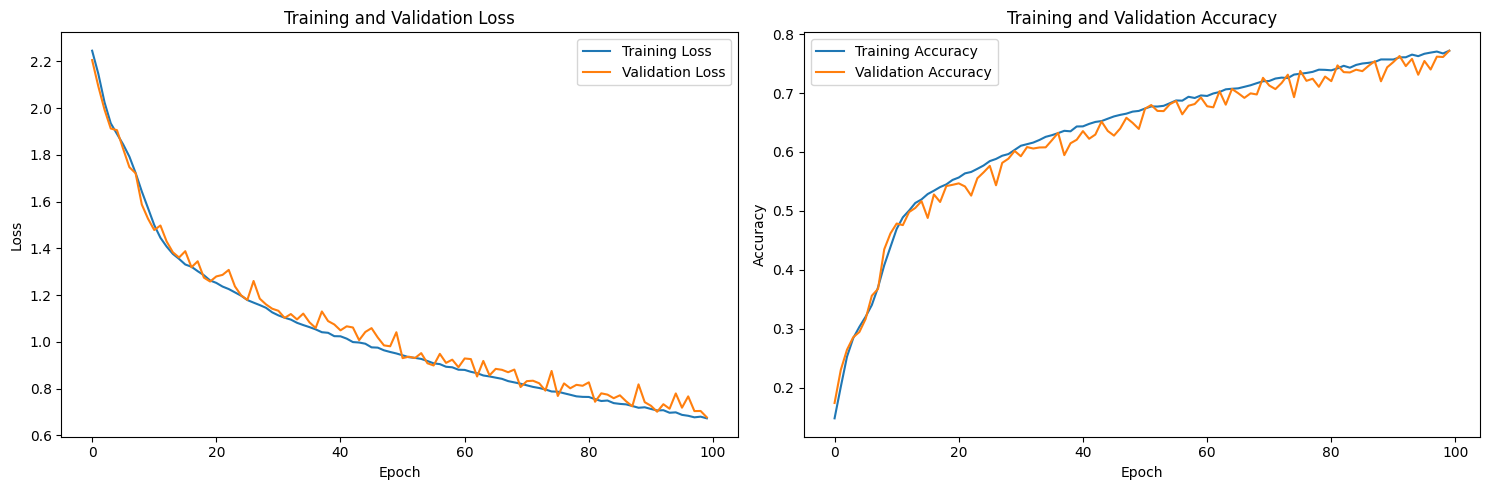

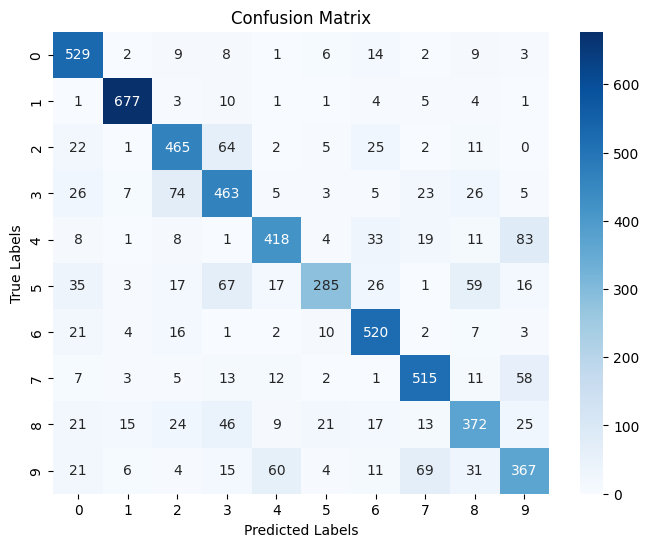

Test Accuracy with Positional Information: 0.7685
Class-wise accuracy with positional information:
Class 0: 0.9074
Class 1: 0.9576
Class 2: 0.7789
Class 3: 0.7268
Class 4: 0.7133
Class 5: 0.5418
Class 6: 0.8874
Class 7: 0.8214
Class 8: 0.6607
Class 9: 0.6241


In [ ]:
# Modify the dataset to include positional information
def add_positional_info(dataset):
    # Create a new list to store modified data
    modified_dataset = []

    for data in dataset:
        # Concatenate the node features (x) with positional information (pos)
        data.x = torch.cat([data.x, data.pos], dim=1)
        modified_dataset.append(data)

    return modified_dataset

# Apply the modification to train, validation, and test datasets
train_dataset_pos = add_positional_info(train_dataset)
val_dataset_pos = add_positional_info(val_dataset)
test_dataset_pos = add_positional_info(test_dataset)

# Create new dataloaders with modified datasets
train_loader_pos = DataLoader(train_dataset_pos, batch_size=batch_size, shuffle=True)
val_loader_pos = DataLoader(val_dataset_pos, batch_size=batch_size, shuffle=False)
test_loader_pos = DataLoader(test_dataset_pos, batch_size=batch_size, shuffle=False)

# Instantiate and train your model with the new input dimension
# The input dimension now includes both features and positional information
sample_pos = train_dataset_pos[0]
input_dim_pos = sample_pos.x.size(1)  # Updated input dimension
num_classes = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_pos = GCN(input_dim=input_dim_pos, num_classes=num_classes).to(device)
model_pos, history_pos = trainer(model_pos, train_loader_pos, val_loader_pos, num_epochs=100, lr=0.001, device=device)

# Plot the training and validation metrics
plot_loss(history_pos)

# Evaluate on test set
test_accuracy_pos, conf_matrix_pos = evaluate_model(model_pos, test_loader_pos)
print(f"Test Accuracy with Positional Information: {test_accuracy_pos:.4f}")

# Calculate class-wise accuracy
test_class_wise_acc_pos = class_wise_accuracy(model_pos, test_loader_pos)

# Print the class-wise accuracy for each class
print("Class-wise accuracy with positional information:")
for i, acc in enumerate(test_class_wise_acc_pos):
    print(f"Class {i}: {acc:.4f}")

From the results, we can see that adding node location information has a significant positive impact on model performance: Accuracy has been greatly improved:

-------------------------------------

Original model test accuracy: 49.77%

Model test accuracy with location information: 76.85%

An increase of about 27 percentage points, which is a huge improvement

The accuracy of all digit categories has been significantly improved：

------------------------------------------

The recognition rate of digit 1 is as high as 95.76%

Even the category with the lowest recognition rate has been improved to about 54%

Confusion between categories is significantly reduced：

---------

In particular, the confusion between digits 2 and 3 is greatly reduced

Why position information is very important:

--------------------------------------------

Digit recognition is  a spatial perception task. The graph structure without position information only retains the node connection relationship and loses the spatial arrangement of pixels, while the position information restores this spatial structure, allowing the model to capture the shape of the number. As an additional feature dimension, position information provides a richer representation for each node. The relative position of the node is crucial for distinguishing numbers with similar shapes (such as 2 and 3, 4 and 9)

### Q8. Optimize your model [20 points]

Lets see how performative you can make your model. You are free to make any design choices you like, as well as changing hyperparameters. Provided detailed summaries of the choices you have made.

Training Size: 45000
Validation Size: 9000
===========  Optimizer  ==================:
      LR: 0.005
      num_epochs: 100

Epoch: 1/100
704/704 [==============================] - 8s 11ms/step - loss: 1.7204 - acc:: 0.4443 - val_loss: 1.6076 - val_acc:: 0.4853
Epoch: 2/100
704/704 [==============================] - 8s 11ms/step - loss: 1.4667 - acc:: 0.5735 - val_loss: 1.6133 - val_acc:: 0.5272
Epoch: 3/100
704/704 [==============================] - 8s 11ms/step - loss: 1.3695 - acc:: 0.6254 - val_loss: 1.5479 - val_acc:: 0.5200
Epoch: 4/100
704/704 [==============================] - 8s 11ms/step - loss: 1.3078 - acc:: 0.6534 - val_loss: 1.4199 - val_acc:: 0.5769
Epoch: 5/100
704/704 [==============================] - 7s 11ms/step - loss: 1.2708 - acc:: 0.6699 - val_loss: 1.3562 - val_acc:: 0.6389
Epoch: 6/100
704/704 [==============================] - 7s 11ms/step - loss: 1.2573 - acc:: 0.6785 - val_loss: 1.1834 - val_acc:: 0.7029
Epoch: 7/100
704/704 [==============================

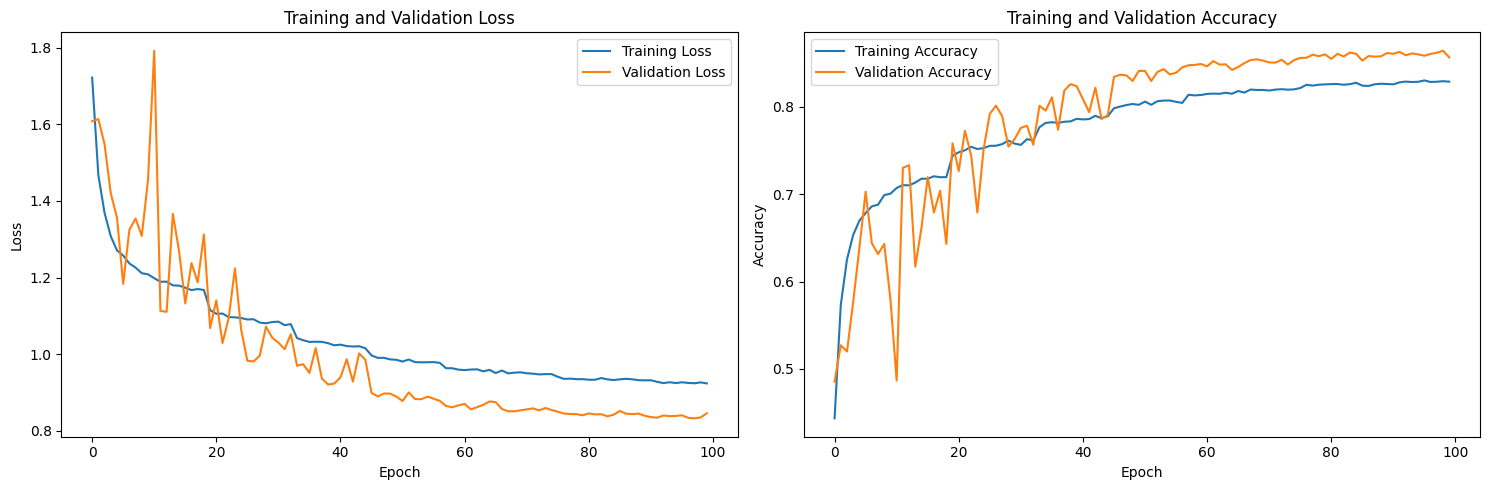

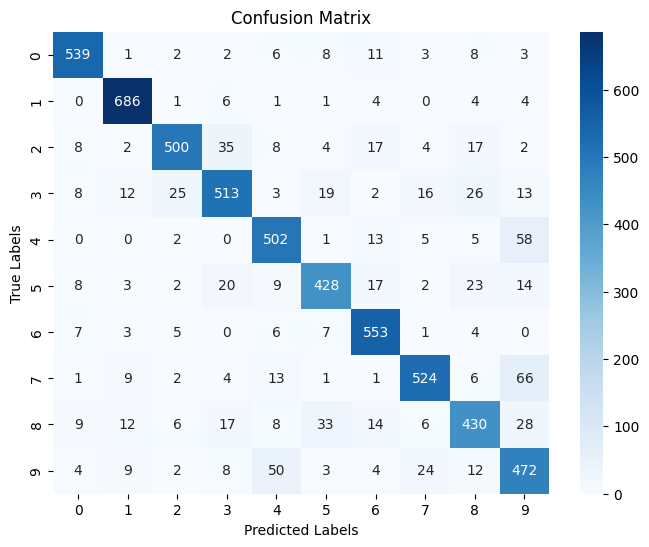

Test Accuracy with Optimized Model: 0.8578
Class-wise accuracy with optimized model:
Class 0: 0.9245
Class 1: 0.9703
Class 2: 0.8375
Class 3: 0.8053
Class 4: 0.8567
Class 5: 0.8137
Class 6: 0.9437
Class 7: 0.8357
Class 8: 0.7638
Class 9: 0.8027


In [ ]:
class OptimizedGCN(torch.nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, dropout_rate=0.2):
        super(OptimizedGCN, self).__init__()
        # Increased capacity with larger hidden dimensions
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim * 2)

        # Batch normalization for better stability
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim * 2)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim * 2)

        # Dropout for regularization
        self.dropout = torch.nn.Dropout(dropout_rate)

        # Linear layers with increased capacity
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, edge_index, batch):
        # First GCN layer with batch norm and dropout
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Second GCN layer with batch norm and dropout
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Third GCN layer with batch norm
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # First fully connected layer with dropout
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)

        # Output layer
        x = self.fc2(x)

        return x

# Instantiate and train the optimized model
input_dim_opt = sample_pos.x.size(1)  # Using the dataset with positional information
hidden_dim = 128
dropout_rate = 0.2
num_classes = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_opt = OptimizedGCN(
    input_dim=input_dim_opt,
    num_classes=num_classes,
    hidden_dim=hidden_dim,
    dropout_rate=dropout_rate
).to(device)

# Use a learning rate scheduler for better convergence
def trainer_with_scheduler(net, train_loader, val_loader, num_epochs=100, lr=5e-3, device='cuda'):
    # Setup random seed
    torch.manual_seed(8)
    torch.cuda.manual_seed(8)
    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}
    print("Training Size: {0}".format(len(train_loader.dataset)))
    print("Validation Size: {0}".format(len(val_loader.dataset)))

    # Create optimizer with weight decay for regularization
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=1e-4)

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )

    print('===========  Optimizer  ==================:')
    print('      LR:', lr)
    print('      num_epochs:', num_epochs)
    print('')

    # Define loss function with label smoothing for better generalization
    CCE = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

    best_val_acc = 0

    for epoch in range(num_epochs):
        # Progress bar setup
        kbar = pkbar.Kbar(target=len(train_loader), epoch=epoch, num_epochs=num_epochs)
        net.train()  # Set the model to training mode
        running_loss = 0.0
        running_acc = 0.0

        for i, data in enumerate(train_loader):
            data = data.to(device)  # Move data to the specified device
            optimizer.zero_grad()

            # Forward pass
            logits = net(data.x, data.edge_index, data.batch)

            # Monitor accuracy
            pred = logits.argmax(dim=1)
            train_acc = pred.eq(data.y).sum().item() / data.num_graphs

            # Calculate loss
            loss = CCE(logits, data.y)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update metrics
            running_loss += loss.item() * data.num_graphs
            running_acc += train_acc * data.num_graphs
            kbar.update(i, values=[("loss", loss.item()),("acc:", train_acc)])

        # Track training metrics
        history['train_loss'].append(running_loss / len(train_loader.dataset))
        history['train_acc'].append(running_acc / len(train_loader.dataset))

        # Validation phase
        net.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for i, data in enumerate(val_loader):
                data = data.to(device)

                # Forward pass
                out = net(data.x, data.edge_index, data.batch)

                # Compute validation metrics
                loss = CCE(out, data.y)
                val_loss += loss.item() * data.num_graphs

                pred = out.argmax(dim=1)
                correct = pred.eq(data.y).sum().item()
                val_acc += correct

        # Average validation metrics
        val_loss /= len(val_loader.dataset)
        val_acc /= len(val_loader.dataset)

        # Update learning rate based on validation loss
        scheduler.step(val_loss)

        # Track validation metrics
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        kbar.add(1, values=[("val_loss", val_loss),("val_acc:", val_acc)])

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = net.state_dict().copy()

    # Load the best model
    net.load_state_dict(best_state)

    return net, history

# Train with the enhanced training function
model_opt, history_opt = trainer_with_scheduler(
    model_opt,
    train_loader_pos,
    val_loader_pos,
    num_epochs=100,
    lr=5e-3,
    device=device,

)

# Plot the training and validation metrics
plot_loss(history_opt)

# Evaluate on test set
test_accuracy_opt, conf_matrix_opt = evaluate_model(model_opt, test_loader_pos)
print(f"Test Accuracy with Optimized Model: {test_accuracy_opt:.4f}")

# Calculate class-wise accuracy
test_class_wise_acc_opt = class_wise_accuracy(model_opt, test_loader_pos)

# Print the class-wise accuracy for each class
print("Class-wise accuracy with optimized model:")
for i, acc in enumerate(test_class_wise_acc_opt):
    print(f"Class {i}: {acc:.4f}")

### Bonus Question:

Implement a CNN design of your choice and compare performance. Are graph structures the optimal way of representing the data?

For those interested, you can find the SOTA MNIST models here: https://paperswithcode.com/sota/image-classification-on-mnist

100%|██████████| 9.91M/9.91M [00:00<00:00, 77.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 4.24MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 34.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.54MB/s]


Epoch 1/10, Train Loss: 0.1312, Train Acc: 0.9593, Val Loss: 0.0639, Val Acc: 0.9784
Epoch 2/10, Train Loss: 0.0458, Train Acc: 0.9855, Val Loss: 0.0429, Val Acc: 0.9866
Epoch 3/10, Train Loss: 0.0323, Train Acc: 0.9898, Val Loss: 0.0553, Val Acc: 0.9826
Epoch 4/10, Train Loss: 0.0262, Train Acc: 0.9914, Val Loss: 0.0336, Val Acc: 0.9908
Epoch 5/10, Train Loss: 0.0226, Train Acc: 0.9927, Val Loss: 0.0559, Val Acc: 0.9844
Epoch 6/10, Train Loss: 0.0172, Train Acc: 0.9943, Val Loss: 0.0422, Val Acc: 0.9899
Epoch 7/10, Train Loss: 0.0137, Train Acc: 0.9957, Val Loss: 0.0484, Val Acc: 0.9886
Epoch 8/10, Train Loss: 0.0136, Train Acc: 0.9955, Val Loss: 0.0409, Val Acc: 0.9886
Epoch 9/10, Train Loss: 0.0113, Train Acc: 0.9960, Val Loss: 0.0377, Val Acc: 0.9910
Epoch 10/10, Train Loss: 0.0109, Train Acc: 0.9964, Val Loss: 0.0342, Val Acc: 0.9924


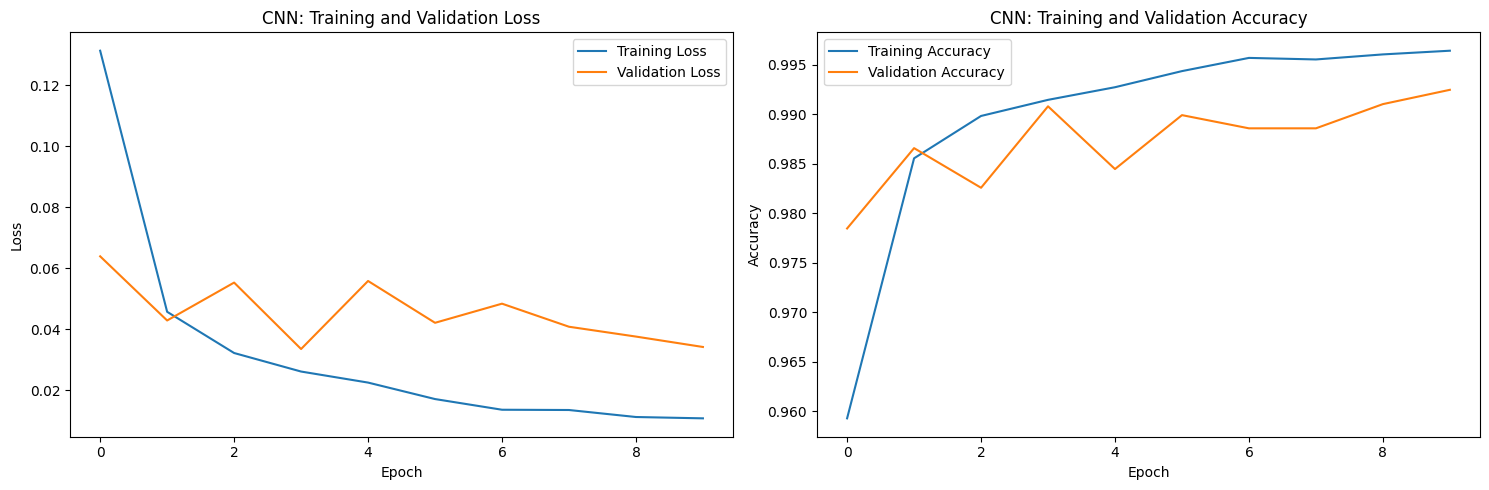

Test Accuracy: 0.9928


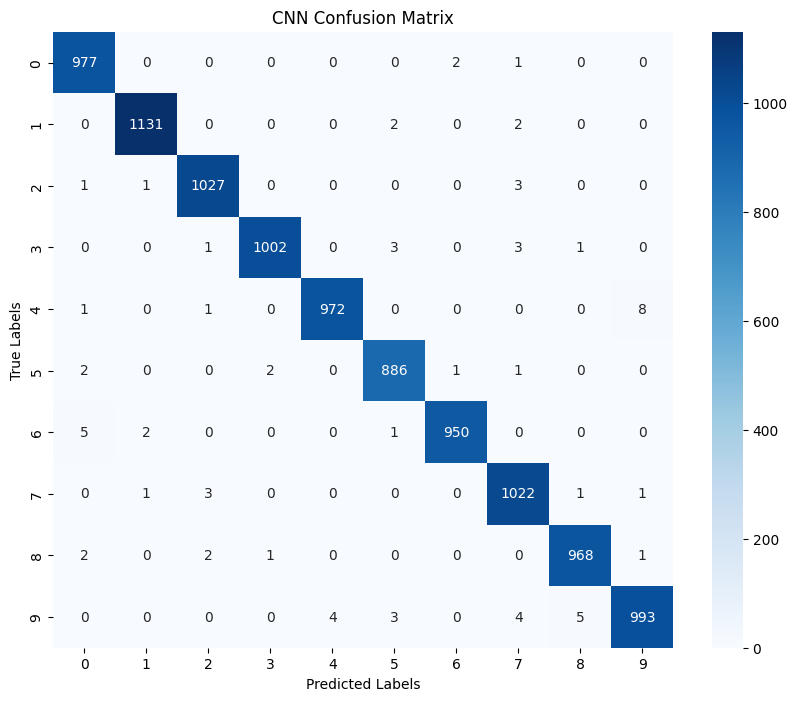

Class-wise accuracy:
Class 0: 0.9969
Class 1: 0.9965
Class 2: 0.9952
Class 3: 0.9921
Class 4: 0.9898
Class 5: 0.9933
Class 6: 0.9916
Class 7: 0.9942
Class 8: 0.9938
Class 9: 0.9841


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics as metrics
import seaborn as sns

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Batch normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

        # Dropout
        self.dropout = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # First convolutional block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))

        # Second convolutional block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))

        # Third convolutional block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))

        # Flatten
        x = x.view(-1, 128 * 3 * 3)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Load the standard MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Use /tmp directory which should be writable
mnist_train = datasets.MNIST('/tmp/data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('/tmp/data', train=False, download=True, transform=transform)

# Split training data into train and validation
train_size = int(0.85 * len(mnist_train))
val_size = len(mnist_train) - train_size
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [train_size, val_size])

# Create dataloaders
train_loader_cnn = DataLoader(mnist_train, batch_size=64, shuffle=True)
val_loader_cnn = DataLoader(mnist_val, batch_size=64, shuffle=False)
test_loader_cnn = DataLoader(mnist_test, batch_size=64, shuffle=False)

# Define the model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cnn = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)

# Training function for CNN
def train_cnn(model, train_loader, val_loader, epochs=10, device='cuda'):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * len(data)
            pred = output.argmax(dim=1, keepdim=True)
            train_correct += pred.eq(target.view_as(pred)).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item() * len(data)
                pred = output.argmax(dim=1, keepdim=True)
                val_correct += pred.eq(target.view_as(pred)).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    return history

# Train the CNN model
cnn_history = train_cnn(model_cnn, train_loader_cnn, val_loader_cnn, epochs=10, device=device)

# Plot the CNN training history
def plot_cnn_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot losses
    ax1.plot(history['train_loss'], label='Training Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('CNN: Training and Validation Loss')
    ax1.legend()

    # Plot accuracies
    ax2.plot(history['train_acc'], label='Training Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('CNN: Training and Validation Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_cnn_history(cnn_history)

# Evaluate the CNN model on test set
def evaluate_cnn(model, test_loader, device):
    model.eval()
    test_loss = 0
    correct = 0
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * len(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

            all_preds.extend(pred.squeeze().cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    test_acc = correct / len(test_loader.dataset)

    print(f'Test Accuracy: {test_acc:.4f}')

    # Calculate confusion matrix
    conf_matrix = metrics.confusion_matrix(all_targets, all_preds)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('CNN Confusion Matrix')
    plt.show()

    # Calculate class-wise accuracy
    class_accuracies = []
    for i in range(10):
        class_indices = [j for j, x in enumerate(all_targets) if x == i]
        if class_indices:
            class_correct = sum(all_preds[j] == all_targets[j] for j in class_indices)
            class_accuracies.append(class_correct / len(class_indices))
        else:
            class_accuracies.append(0)

    print("Class-wise accuracy:")
    for i, acc in enumerate(class_accuracies):
        print(f"Class {i}: {acc:.4f}")

    return test_acc, conf_matrix, class_accuracies

# Evaluate the CNN model
cnn_test_acc, cnn_conf_matrix, cnn_class_acc = evaluate_cnn(model_cnn, test_loader_cnn, device)



**Analysis: CNN vs GCN**

----------------------------------------------

CNNs are highly effective for image classification tasks like MNIST because:

They can capture spatial hierarchies in the data through convolutional layers

They preserve the 2D structure of the images

They have proven to be highly efficient for image recognition tasks

GCNs represent the data differently:

They work on graph structures rather than grid-like data

In the MNIST dataset, pixels are converted to nodes in a graph

This representation may lose some spatial information unless position is explicitly included

Conclusion:

While GCNs can perform well on MNIST data when properly structured with positional
information, traditional CNNs are more suitable for this particular task
as they capture the 2D structure of images. However, GCNs excel in
applications where the data has an inherent graph structure, such as molecular data,
social networks etc.